## Bag Of Chars and MLP

In this section, we introduce two new concepts that will be used in conjunction. The first concept, **Bag of Chars**, serves as an alternative to the classic bigram approach discussed in the previous notebook. Unlike bigrams, which consider pairs of characters sequentially, **Bag of Chars** offers a more flexible technique for generating words.

### Explanation:

- **Bag of Chars:** This technique involves treating each character in a word as an independent entity, similar to how a bag of words model operates in natural language processing. Instead of focusing on character pairs (bigrams), we consider the frequency distribution and relationships between individual characters across words.
  
- **MLP (Multi-Layer Perceptron):** Alongside Bag of Chars, we employ an MLP for prediction and generation tasks. An MLP is a type of neural network architecture that consists of multiple layers of nodes (neurons), each layer fully connected to the next. It excels in learning complex patterns and relationships within data, which is advantageous when working with the flexible character representations provided by Bag of Chars.

By combining Bag of Chars with an MLP, we aim to enhance the flexibility and effectiveness of word generation models compared to traditional bigram approaches. This setup allows us to capture more nuanced dependencies between characters and generate more diverse and contextually appropriate sequences of characters or words.

In [1]:
from makemore.config import RAW_DATA_DIR, PROCESSED_DATA_DIR
print(f"RAW_DATA_DIR: {RAW_DATA_DIR}")
print(f"PROCESSED_DATA_DIR: {PROCESSED_DATA_DIR}")

2024-06-16 15:43:47.745 | INFO     | makemore.config:<module>:11 - PROJ_ROOT path is: /home/linx/code_workspace/makemore


RAW_DATA_DIR: /home/linx/code_workspace/makemore/data/raw
PROCESSED_DATA_DIR: /home/linx/code_workspace/makemore/data/processed


In [2]:
# Download the dataset
!python ../makemore/dataset.py

2024-06-16 15:43:58.871 | INFO     | makemore.config:<module>:11 - PROJ_ROOT path is: /home/linx/code_workspace/makemore
2024-06-16 15:43:58.875 | INFO     | __main__:main:22 - Downloading dataset...
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.68it/s]
2024-06-16 15:43:59.148 | INFO     | __main__:main:27 - namex.txt correctly download!


In [3]:
DATASET_NAME = "names.txt"

# Read words
with open(RAW_DATA_DIR / DATASET_NAME, "r") as names_file:
    names = names_file.readlines()

print(names[:10])

# Remove the \n from all the names
names = [name[:-1] for name in names]

names[:10]

['emma\n', 'olivia\n', 'ava\n', 'isabella\n', 'sophia\n', 'charlotte\n', 'mia\n', 'amelia\n', 'harper\n', 'evelyn\n']


['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [6]:
# Generate decoder and encoder for chars
chars = ".qwertyuiopasdfghjklzxcvbnm" # All available letters in latin alphabet plus .
decoder, encoder = {}, {}

for i, ch in enumerate(chars):
    encoder[ch] = i
    decoder[i] = ch

encoder, decoder  

({'.': 0,
  'q': 1,
  'w': 2,
  'e': 3,
  'r': 4,
  't': 5,
  'y': 6,
  'u': 7,
  'i': 8,
  'o': 9,
  'p': 10,
  'a': 11,
  's': 12,
  'd': 13,
  'f': 14,
  'g': 15,
  'h': 16,
  'j': 17,
  'k': 18,
  'l': 19,
  'z': 20,
  'x': 21,
  'c': 22,
  'v': 23,
  'b': 24,
  'n': 25,
  'm': 26},
 {0: '.',
  1: 'q',
  2: 'w',
  3: 'e',
  4: 'r',
  5: 't',
  6: 'y',
  7: 'u',
  8: 'i',
  9: 'o',
  10: 'p',
  11: 'a',
  12: 's',
  13: 'd',
  14: 'f',
  15: 'g',
  16: 'h',
  17: 'j',
  18: 'k',
  19: 'l',
  20: 'z',
  21: 'x',
  22: 'c',
  23: 'v',
  24: 'b',
  25: 'n',
  26: 'm'})

In [4]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

First, we will attempt to understand the structure based on the image shown below. This is an MLP where the input consists of the three previous characters. The goal of the model is to predict the next character given a contextual block. These characters are first transformed into a vector space called embeddings, which is a crucial mathematical representation for Language Model (LM) tasks.

Once the characters are converted into embeddings, they are concatenated into a single vector. This vector serves as the input to a hidden layer, which then feeds into the output layer. The output layer has a size of 27, corresponding to the 27 available characters. The model uses a cross-entropy loss function to compute the probability distribution over these characters, predicting the most probable next character.

All the discussed parameters can be adjusted, and it is advisable not to hardcode them to allow for testing different configurations effectively.

### Parameters:
- Input size (number of previous characters)
- Embedding dimension
- Hidden layer size
- Output layer size (number of characters)
- Loss function (e.g., cross-entropy)
- Optimization algorithm and its parameters (e.g., learning rate)
- Number of training epochs
- Batch size
- Dropout rate (if used)
- Activation functions


![alt text](/home/linx/code_workspace/makemore/reports/figures/word_embedding.ppm)

We will start by building the dataset that we will use to train the model

In [13]:
# Context window dimension
context_size = 3 # As in the paper

# Store dataset
X, Y = [], []

for name in names:
    # Starting context
    context = [0] * context_size

    for ch in name:
        # Encode ch in an int
        i_ch = encoder[ch]
        # Store couple
        X.append(context)
        Y.append(i_ch)
        # Update context
        context = context[1:] + [i_ch]

# Store dataset in torch tensor
X = torch.tensor(X)
Y = torch.tensor(Y)

print(f"Dataset lenght: {len(Y)}")

Dataset lenght: 196112


Always visualize of the data are correctly stored in the tensors

In [17]:
for prev, next in zip(X[:10], Y[:10]):
    prev_ch = [decoder[i.item()] for i in prev]
    next_ch = decoder[next.item()]

    print(f"{prev_ch} --> {next_ch}")

['.', '.', '.'] --> e
['.', '.', 'e'] --> m
['.', 'e', 'm'] --> m
['e', 'm', 'm'] --> a
['.', '.', '.'] --> o
['.', '.', 'o'] --> l
['.', 'o', 'l'] --> i
['o', 'l', 'i'] --> v
['l', 'i', 'v'] --> i
['i', 'v', 'i'] --> a


Is noe the time to build out model. Best practice is to start from a forward with only a some data without using the backpropgation. This is done in order to understand if all computations are working correctly

In [38]:
# Embedding matrix: put chars in a vector space
embedding_dim = 2
C = torch.randn(27, embedding_dim)

# We now need to extract prev and next and convert the chars into the embeddings
n = 5
x_example, y_example = X[:n], Y[:n]

# Compute embeddings
embeddings = C[x_example]

# Concatenate embeddings of the same context
embeddings = embeddings.view((-1, embedding_dim * context_size))

# First hidden layer
W1 = torch.randn(embedding_dim * context_size, 100)
b1 = torch.randn(100)

out = (embeddings @ W1 + b1).tanh()

# Output layer
W2 = torch.randn(100, 27)
b2 = torch.randn(27)

out = out @ W2 + b2

# Compute loss
loss = F.cross_entropy(out, y_example)

tensor(13.8173)

Let's now train the network

In [81]:
# Hyperparameters
EPOCHS = 50000
lr = 0.1
embedding_dim = 2
hidden_layer_size = 100
batch_size = 32

In [82]:
# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available. GPU is ready for use.")
else:
    print("CUDA is not available. Using CPU.")

CUDA is not available. Using CPU.


In [83]:
# Parameters
C = torch.randn(27, embedding_dim)
W1 = torch.randn(embedding_dim * context_size, hidden_layer_size)
b1 = torch.randn(hidden_layer_size)
W2 = torch.randn(hidden_layer_size, 27)
b2 = torch.randn(27)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [84]:
# Split the dataset
n1 = round(len(Y) * 0.80)
n2 = round(len(Y) * 0.90)

X_train, Y_train = X[:n1], Y[:n1]
X_val, Y_val = X[n1:n2], Y[n1:n2]
X_test, Y_test = X[n2], Y[n2:]

print(f"n1: {n1}, n2: {n2}")
print(f"Train lenght: {len(Y_train)}, Validation lenght: {len(Y_val)}, Test lenght: {len(Y_test)}")

n1: 156890, n2: 176501
Train lenght: 156890, Validation lenght: 19611, Test lenght: 19611


In [101]:
stats = {"epoch": [],
         "loss": [],
         "min_loss": 200,
         "best_model_params": []}

# Training
for epoch in range(EPOCHS):
    # Mini-batch
    i = torch.randint(low=0, high=len(Y_train), size=(batch_size,))
    x_batch = X_train[i]
    y_batch = Y_train[i]

    # Forward
    emb = C[x_batch].view((-1, embedding_dim * context_size))
    out = (emb @ W1 + b1).tanh()
    out = out @ W2 + b2
    loss = F.cross_entropy(out, y_batch)

    # Set grad to zero
    for p in parameters:
        p.grad = None

    # Backpropagation
    loss.backward()

    # Update
    for p in parameters:
        lr = lr if epoch < 10000 else 0.0001
        p.data -= lr * p.grad

    # Store stats
    stats["epoch"].append(epoch)
    stats["loss"].append(loss.item())
    if loss.item() < stats["min_loss"]:
        stats["min_loss"] = loss.item() 

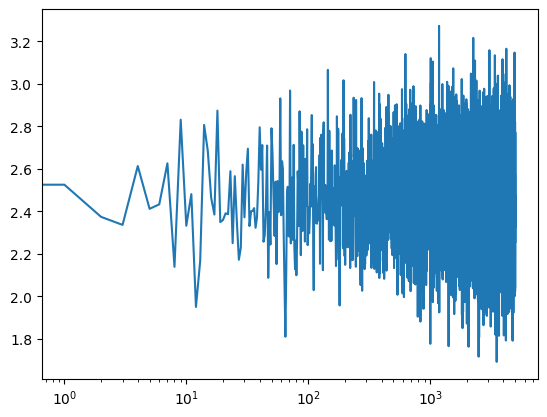

Min loss: 1.6917173862457275


In [104]:
plt.plot(stats["epoch"], stats["loss"])
plt.xscale("log")
plt.show()

print(f"Min loss: {stats['min_loss']}")